In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import os
from pathlib import Path 
import traceback
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt

from hyperbolicTSNE import Datasets
from hyperbolicTSNE import Datasets, SequentialOptimizer, initialization, HyperbolicTSNE
from hyperbolicTSNE.cost_functions_ import HyperbolicKL, GaussianKL
from hyperbolicTSNE.util import find_last_embedding, opt_config, initialize_logger, write_data, store_visuals
from hyperbolicTSNE.data_loaders import load_mnist
from hyperbolicTSNE.hd_mat_ import hd_matrix
from hyperbolicTSNE.visualization import animate, plot_poincare

# Dataset generation code
Generate a specific set of samples we want to use.
Right now we want 10 samples of data with labels 2 and 4.

In [26]:
# MNIST DATA 

# n_samples = 20             # How much to sample from each class
# dataX, dataLabels = load_mnist(data_home=data_home)
# print(dataX.shape, dataLabels.shape)

# indices_2 = np.where(dataLabels == 2)
# indices_4 = np.where(dataLabels == 4)

# samples_idx_2 = np.random.choice(indices_2[0], size=n_samples, replace=False)
# samples_idx_4 = np.random.choice(indices_4[0], size=n_samples, replace=False)

# print(samples_idx_2)
# print(samples_idx_4)

# print(dataLabels[samples_idx_2])
# print(dataLabels[samples_idx_4])

# labels_2 = dataLabels[samples_idx_2]
# labels_4 = dataLabels[samples_idx_4]
# sample_labels = np.concatenate((labels_2, labels_4), axis=0)

# samples_2 = dataX[samples_idx_2]        # samples of number 2
# samples_4 = dataX[samples_idx_4]        # samples of number 4
# sample_data = np.concatenate((samples_2, samples_4), axis=0)    # Contains both 2 and 4 

# print(sample_data.shape)    

In [27]:
from scipy.stats import multivariate_normal

def generate_linear_hierarchical_data(n_samples, n_clusters, n_dim, start, end):
    """ 
    Generate a "hierarchical" dataset where we basically generate clusters from "left" to "right" 
    """
    # n_samples must be a integer multiple of n_clusters
    points_per_cluster = n_samples
    cluster_distances = np.abs(end - start) / n_clusters                            # distance between each cluster
    cluster_centers = [start + i * cluster_distances for i in range(n_clusters)]    # centers of each cluster

    # Generate data
    data = []
    for center in cluster_centers:
        cluster_center = np.ones(n_dim) * center
        cov = (cluster_distances / 3) 
        # cov = 1
        cluster_cov = np.identity(n_dim) * cov
        #cluster_cov = np.identity(n_dim)
        cluster_data = multivariate_normal.rvs(mean=cluster_center, cov=cluster_cov, size=points_per_cluster)
        data.append(cluster_data)

    # Generate labels
    labels = []
    for i in range(n_clusters):
        labels = labels + [i for _ in range(points_per_cluster)]

    return np.array(data), np.array(labels)


# Custom data, Uniform distrib.
from scipy.stats import uniform 
def generate_uniform_clusters(n_samples, n_dim, b1, b2):
    # n_samples = 500
    # n_dim = 10
    # b1 = 1000000
    # b2 = 100

    # Bounds for first distribution
    lb_1 = np.ones(n_dim) * (-b1)
    ub_1 = np.ones(n_dim) * (-b2)
    widths_1 = ub_1 - lb_1 

    # Bounds for 2nd distribution
    lb_2 = np.ones(n_dim) * b2
    ub_2 = np.ones(n_dim) * b1
    widths_2 = ub_2 - lb_2

    # Draw samples 
    samples_1 = uniform.rvs(loc=lb_1, scale=widths_1, size=(n_samples, n_dim))
    samples_2 = uniform.rvs(loc=lb_2, scale=widths_2, size=(n_samples, n_dim))

    dataX = np.concatenate((samples_1, samples_2), axis=0)
    labels = [0 for _ in range(n_samples)] + [1 for _ in range(n_samples)]
    dataLabels = np.array(labels)

    return dataX, dataLabels

# Preperation for running embedding
Get the distance matrix and affinity matrix of our samples
Generate custom dataset (see below)

In [28]:
n_samples = 5
n_clusters = 2
n_dim = 2
start = -100
end = 100

# Generate data
dataX, dataLabels = generate_linear_hierarchical_data(n_samples, n_clusters, n_dim, start, end)
dataX = dataX.reshape((dataX.shape[0] * dataX.shape[1], dataX.shape[2]))

# Visualize generated data

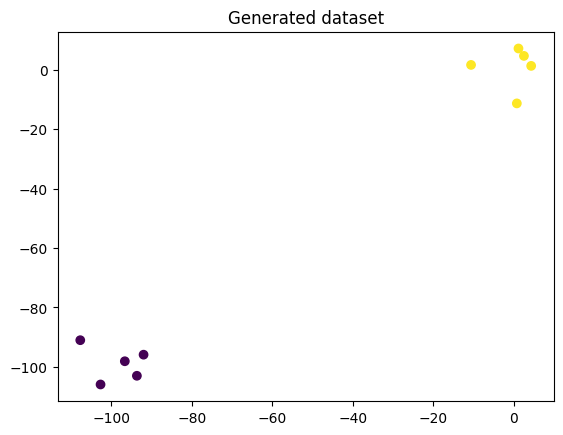

In [29]:
plt.scatter(dataX[:, 0], dataX[:, 1], c=dataLabels)

plt.title("Generated dataset")
plt.show()

In [30]:
hd_params = {"perplexity": n_samples}
D, V = hd_matrix(X=dataX, D=None, V=None,
                    knn_method="sklearn", metric="euclidean", n_neighbors=n_samples, knn_params=None,
                    hd_method="vdm2008", hd_params=hd_params, verbose=1)

Computing the kNN D matrix with k=9 nearest neighbors...
Using sklearn NearestNeighbor, an exact method, for the knn computation
Indexed 10 samples in 0.000s...
Computed neighbors for 10 samples in {duration:.3f}s...
`hd_method` set to `vdm2008`, running with perplexity 5. Returns (D, V)
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 79.151604


Initialize configuration parameters and stuff

In [31]:
data_home = "datasets"
log_path = "temp/poincare/"  # path for saving embedding snapshots
grad_path = "temp/grad/"     # NOTE: We will manually calculate the gradients

seed = 42

dataset = Datasets.MNIST
num_points = [-1]
perplexities = [50]
correct_gradient = True                          # NOTE: Recompile with correct flag (GRAD_FIX flag)
exact = True                                     # Exact computation or BH estimation of gradient
pca_components = 0                               # Whether to use pca initialization of high dim. data or not
grad_scale_fix = True                            # Whether we multiply the gradient by the inverse metric tensor of hyperbolic space or not
                                                 # Note that the correct hyperoblic gradient has an inverse metric tensor factor

# Simple experiment with no exaggeration
exaggeration_factor = 12
ex_iterations = 0
main_iterations = 1000
cf = GaussianKL

# Run embedding
Code below runs the embedding procedure for our specified dataset

We compute embeddings for the correct gradient version, and then manually compute the wrong gradient using the emebddings produced by the correct gradient

In [32]:
# Compute initial embedding in Poincare disk (PCA embedding)
X_embedded = initialization(
    n_samples=dataX.shape[0], 
    n_components=2,
    X=dataX,
    random_state=seed,
    method="random"
) 

# Initialize config and parameters
learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)

opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, exact=exact, grad_scale_fix=True, grad_fix=correct_gradient)
opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 

log_path_cf = log_path + f"correct_grad_{correct_gradient}/"
grad_path_grad = grad_path + f"correct_grad_{correct_gradient}/"

opt_params, opt_conf = initialize_logger(opt_params, opt_conf, log_path_cf, grad_path_grad)
opt_params["cf_params"].update({"grad_fix" : correct_gradient})     # So the cost function knows which gradient to use
opt_params["cf_params"].update({"var" : 1})

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'cf': <class 'hyperbolicTSNE.cost_functions_.GaussianKL'>, 'learning_rate_ex': 0.0008333333333333334, 'learning_rate_main': 0.0008333333333333334, 'exaggeration': 12, 'exaggeration_its': 0, 'gradientDescent_its': 1000, 'vanilla': False, 'momentum_ex': 0.5, 'momentum': 0.8, 'exact': True, 'area_split': False, 'n_iter_check': 10, 'size_tol': 0.999, 'grad_scale_fix': True, 'grad_fix': True}


In [33]:
# Set up H-TSNE object 
htsne = HyperbolicTSNE(
    init=X_embedded, 
    n_components=2, 
    metric="precomputed",
    verbose=1, 
    opt_method=SequentialOptimizer,         # the optimizater we use
    opt_params=opt_params              # the parameters for the optimizers
    )

# Compute embedding:
try:
    hyperbolicEmbedding = htsne.fit_transform((D, V))
    
except ValueError:
    hyperbolicEmbedding = find_last_embedding(log_path)
    traceback.print_exc()

[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent: 0it [00:00, ?it/s]


Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: -31.50562 grad_norm: 1.24213e+16:  14%|█▍        | 140/1000 [00:00<00:00, 916.71it/s]

4


Animation being saved to: results/gradient_vis_images/gradienttesting_correctgrad_True.gif


Animating:   0%|          | 0/29 [00:00<?, ?it/s]/Users/haoranxia/Thesis-Delft/hyperbolic-tsne/hyperbolicTSNE/visualization.py:322: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=29.
  anim = FuncAnimation(fig, update, frames=len(scatter_data), interval=50, blit=True, save_count=50)
MovieWriter ffmpeg unavailable; using Pillow instead.
Animating: : 32it [00:00, 41.24it/s]                      


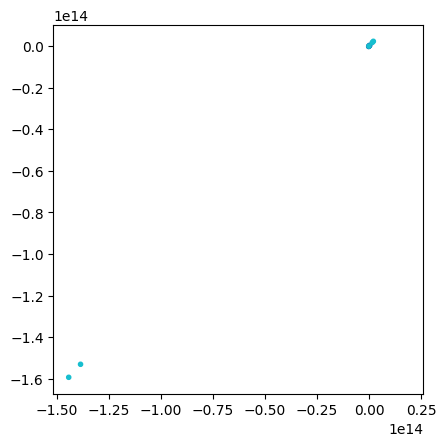

In [34]:
 # Store visuals
save_folder = "results/gradient_vis_images"
file_name = f"{save_folder}/gradienttesting_correctgrad_{correct_gradient}"

# Create folder if it doesn't exist
path = Path(save_folder)
path.mkdir(parents=True, exist_ok=True)

fig = plot_poincare(hyperbolicEmbedding, dataLabels)
fig.savefig(f"{file_name}.png")

# Save animation
animate(opt_params["logging_dict"], dataLabels, f"{file_name}.gif", fast=True, plot_ee=True)

# Gradient analysis notes:

- Upon preliminary observations, the true gradient tends to push embeddings towards the outer edge much more than the wrong gradient. 

- The correct gradient needs a bit of time before it starts moving the points outwards. The incorrect one starts moving faster.

- Possible explanation: 
$d^H_{ij}$ amplifies all the forces. The $F_{rep}$ force for points that are far away always contributes to the gradient because the t-distribution has heavy tails, so if points are already far away, they still have a considerable effect on eachother. 
[Analyze repulsive forces contribution?]

- Things to try to get a sense of the differences in gradients? Plot norms, plot difference in norms, ...


# Experiment (1)
Compute both gradients for the same embeddings. Choice of embedding should be set manually

In [35]:
from gradient_experiments import GradientComparisons
from pathlib import Path

embedding_folder_path = "temp/poincare/correct_grad_True"              # Where our embeddings are 
output_folder_path = "results/gradient_comparisons"                    # Where to store our results
V = V                                                                  # High dim. affinity matrix, precomputed

# For each type of gradient, calculate the gradients and store the results
for correct_gradient in [True, False]:
    # Initialize config and parameters
    learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)

    opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, exact=exact, grad_scale_fix=True, grad_fix=correct_gradient)
    opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 
    opt_params["cf_params"].update({"grad_fix" : correct_gradient})         # So the cost function knows which gradient to use
    params = opt_params["cf_config_params"] | opt_params["cf_params"]       # Params to initialize cf

    key = f"linear_hierarchical_data_nclusters:{n_clusters}_ndata:{n_samples}"
    cf = HyperbolicKL(n_components=2, other_params=params)                  
    
    # Run experiment
    Experiment_Gradients = GradientComparisons(embedding_folder_path, cf, key)  
    Experiment_Gradients.compute_gradients(V, correct_gradient, output_folder_path)

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.


# Plot of correct and incorrect gradient

Plot the norms of some datapoint i with the correct and incorrect gradients

In [36]:
node = 5

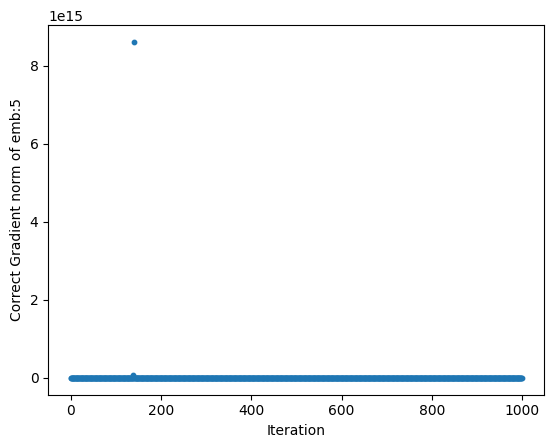

In [37]:
# Plot correct gradient data of node {node}
correct_grad_directory = Path("results/gradient_comparisons/correct_grad_True")

# Loop over all gradient files
files = sorted(correct_grad_directory.iterdir(), key=lambda file: int(file.name.split(".")[0]))
data_size = len(files)
grads_c = np.zeros((data_size, 2))


for idx, grad_file in enumerate(files):
    data = np.loadtxt(str(grad_file), delimiter=',')
    grads_c[idx] = data[node]

# Establish x-coordinates
xs = np.array([x for x in range(data_size)])   

# Compute norms
grads_c = np.linalg.norm(grads_c, axis=1)

plt.scatter(xs, grads_c, s=10)
plt.ylabel(f"Correct Gradient norm of emb:{node}")
plt.xlabel("Iteration")
plt.show()

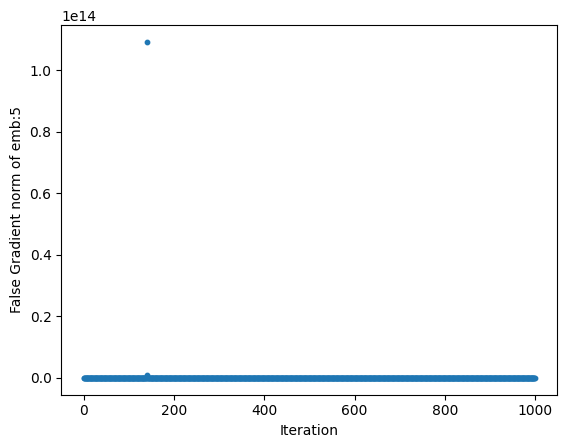

In [38]:
# Plot norms of wrong gradient
# Plot correct gradient data of node {node}
correct_grad_directory = Path("results/gradient_comparisons/correct_grad_False")

# Loop over all gradient files
files = sorted(correct_grad_directory.iterdir(), key=lambda file: int(file.name.split(".")[0]))
data_size = len(files)
grads_w = np.zeros((data_size, 2))

for idx, grad_file in enumerate(files):
    data = np.loadtxt(str(grad_file), delimiter=',')
    grads_w[idx] = data[node]

# Compute norms
grads_w = np.linalg.norm(grads_w, axis=1)

plt.scatter(xs, grads_w, s=10)
plt.ylabel(f"False Gradient norm of emb:{node}")
plt.xlabel("Iteration")
plt.show()

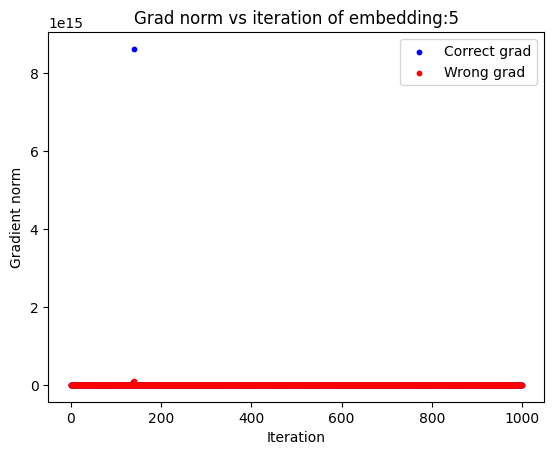

In [39]:
plt.scatter(xs, grads_c, s=10, c="blue", label="Correct grad")
plt.scatter(xs, grads_w, s=10, c="red", label="Wrong grad")

plt.title(f"Grad norm vs iteration of embedding:{node}")
plt.ylabel("Gradient norm")
plt.xlabel("Iteration")

plt.legend()
plt.show()

## Ideas to experiment further with
wg = wrong gradient, cg = correct gradient

1. It seems that the wg is in general much larger in magnitude than cg
2. wg starts off large, cg starts of small
3. cg peaks around iteration ~300
4. wg has a peak, but not a very obvious one like cg
5. When points are far away enough, i.e. when embeddings have converged, the gradients are more or less the same

## Initial ideas:
1. Lower iterations --> lower distances. Do smaller distances affect gradients?
2. $q^{H}_{ij}$ is very off at the beginning. I can analyze the relationship of $q^{H}_{ij}$ and gradient (norm)
3. In depthly investigate iteration (-1), seems to be the most straightforward place to start


# Gradient visualization

In [40]:
# Lets examine gradients of step 0
gradients_directory = Path("results/gradient_comparisons")

# The iteration we want to analyze
emb_it = 500                              

# Load gradients corresponding to "emb_it"
data = dict()
for correct_grad in [True, False]:
    gradient_folder = Path(f"results/gradient_comparisons/correct_grad_{correct_grad}")
    # Load gradient data from the iteration we want
    gradient_file_path = Path(f"{gradient_folder}/{emb_it}.csv")
    gradient_data = np.loadtxt(str(gradient_file_path), delimiter=',')
    key = "Correct_Grad" if correct_grad else "Wrong_Grad"
    data[key] = gradient_data

# Load embedding corresponding to "emb_it"
embeddings_directory = Path("temp/poincare/correct_grad_True/solver_gradient_descent_sequential_opt_1")
emb_file_path = Path(f"{embeddings_directory}/{emb_it}.csv")
emb_data = np.loadtxt(str(emb_file_path), delimiter=',')
data["Emb"] = emb_data

FileNotFoundError: temp/poincare/correct_grad_True/solver_gradient_descent_sequential_opt_1/500.csv not found.

In [55]:
# Testing data shape and such. Sanity checks

# for key in data:
#     print(key)
#     print(data[key])
#     print()

print(data["Emb"].shape)
print(data["Emb"][:, 0])
print(data["Emb"][0])
# Note that the indices of dataLabels correspond to indices of data["Emb"]
print(dataLabels)

(10, 2)
[ 0.45826009  0.45522957  0.45761847  0.46014575  0.45780186 -0.4589705
 -0.45655406 -0.46064741 -0.45943713 -0.45353056]
[0.45826009 0.50234489]
[0 0 0 0 0 1 1 1 1 1]


So what do we do now with the data?

**data** contains computed gradients for each version, and the corresponding embedding 
- Embeddings are really close to eachother
- Zoom in, plot the points, and visualize the gradient vectors for each point?
- Compute angle differences between gradients? What parameters may be influencing this?

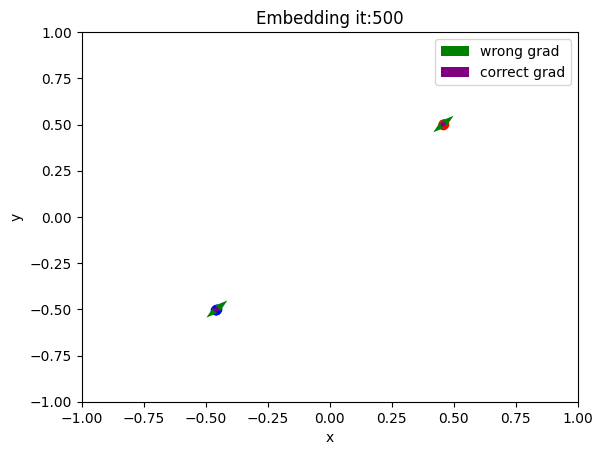

In [60]:
from matplotlib import pyplot as plt

scaling_factor = 1
grad_scaling_factor = 1

# Plot embedding points
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the embeddings/data
scaled_data = data["Emb"] * scaling_factor

# In our current situation we have 2 clusters with n_samples elements each
ax.scatter(scaled_data[:n_samples, 0], scaled_data[:n_samples, 1], color='red')
ax.scatter(scaled_data[n_samples:, 0], scaled_data[n_samples:, 1], color='blue')

# Plot the gradients 
scaled_wrong_grad = data["Wrong_Grad"] * grad_scaling_factor
ax.quiver(scaled_data[:, 0], scaled_data[:, 1], scaled_wrong_grad[:, 0], scaled_wrong_grad[:, 1],
          angles='xy', scale_units='xy', scale=1, color='green', label="wrong grad")

# Correct gradient seems to be ~3000 times smaller than wrong gradient (at the start)
scaled_correct_grad = data["Correct_Grad"] * grad_scaling_factor
ax.quiver(scaled_data[:, 0], scaled_data[:, 1], scaled_correct_grad[:, 0], scaled_correct_grad[:, 1],
          angles='xy', scale_units='xy', scale=1, color='purple', label="correct grad")

# Set axis limits
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Add labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Embedding it:{emb_it}')

ax.legend()

# Show the plot
plt.show()

Code to find affinity matrices

In [63]:
# High dimensional affinities
P = V

# Low dimensional affinities, computed from embeddings 
def hyp_dist(y1, y2):
    diff = y1 - y2
    num = diff.dot(diff)                         # numerator
    denum = (1 - y1.dot(y1)) * (1 - y2.dot(y2))  # denumerator
    dist = np.arccosh(1 + 2 * (num / denum))

    return dist

def compute_affinities(embedding_data):
    Q = np.zeros((embedding_data.shape[0], embedding_data.shape[0]))
    for i in range(Q.shape[0]):
        for j in range(i + 1, Q.shape[1]):
            dist = hyp_dist(embedding_data[i], embedding_data[j])       # hyp. distance
            dist = 1. / (1 + dist**2)                                   # t-distrib. "distance"
            Q[i][j] = dist
            Q[j][i] = dist

    # Normalize distances to probabilities
    # return Q / Q.sum()
    return Q / Q.sum()

Q = compute_affinities(data["Emb"])
print(Q)
print(data["Emb"])

[[0.         0.02263579 0.02264177 0.02263958 0.0226419  0.00188323
  0.00189714 0.00187359 0.00188055 0.0019146 ]
 [0.02263579 0.         0.02263817 0.02262547 0.02263754 0.00190064
  0.00191474 0.00189087 0.00189792 0.00193243]
 [0.02264177 0.02263817 0.         0.02263762 0.02264203 0.00188691
  0.00190087 0.00187724 0.00188422 0.00191837]
 [0.02263958 0.02262547 0.02263762 0.         0.02263824 0.00187241
  0.00188621 0.00186285 0.00186975 0.00190352]
 [0.0226419  0.02263754 0.02264203 0.02263824 0.         0.00188586
  0.0018998  0.00187619 0.00188317 0.00191729]
 [0.00188323 0.00190064 0.00188691 0.00187241 0.00188586 0.
  0.02263804 0.02264009 0.0226419  0.02262196]
 [0.00189714 0.00191474 0.00190087 0.00188621 0.0018998  0.02263804
  0.         0.02263048 0.02263633 0.02263589]
 [0.00187359 0.00189087 0.00187724 0.00186285 0.00187619 0.02264009
  0.02263048 0.         0.02264102 0.02260747]
 [0.00188055 0.00189792 0.00188422 0.00186975 0.00188317 0.0226419
  0.02263633 0.022641

# Analysis of behaviour at beginning (early iterations)

1. hyp. distances are small $d^{H}_{ij}$ approaches 0 (since $cosh^{-1} goes to 0), since its argument goes to 1.

2. This means t-distrib. probability goes to 1, $(1 + (d^{H}_{ij})^2)^{-1}$ goes to 1.
So once normalized, all probabilities $q^{H}_{ij}$ are almost the same for all $ij$, so we basically have an uniform distribution for $q^{H}_{ij}$

3. Why are the wrong gradients so much bigger?

Correct Gradient expression:
$$ 4  \sum_{j} (p_{ij} - q^{H}_{ij}) (1 + (d^{H}_{ij})^2)^{-1}  d^{H}_{ij} \frac{d^{H}_{ij}}{y_i}$$

\
Wrong Gradient expresion:
$$ 4  \sum_{j} (p_{ij} - q^{H}_{ij}) (1 + (d^{H}_{ij})^2)^{-1} \frac{d^{H}_{ij}}{y_i}$$

\
Because in early iterations, $ d^{H}_{ij} $ is approximately 0, the correct gradient is very small, until points haved moved sufficiently for this term to increase in value.

Can this possibly replace early exaggeration? Maybe.. 
At the beginning, points are updated in very small amounts. But this applies to both attractive and repulsive forces.

At some points, points are "distant" enough, for $ d^{H}_{ij} $ to not matter much anymore. 

$ d^{H}_{ij} $ goes up a lot (to possibly infinity) for larger distances. This means that forces between distant points get heavily amplified. Is this an issue though? Since very distant forces should be more or less 0?

4. Is the use of the t-distribution justified in hyperbolic space?
Is it making repellant points feel a repellant force for way too far distances?
What do p, q look like for points far away? Is the heavy-tailedness a problem in hyperbolic space?

Despite large distances, $ q^{H}_{ij} $ is never able to reach the "correct" probabilities due to the use of the t-distribution? Since the heavy tails requires too big of distances for things to converge properly. Hence points keep getting pushed out? 

We can try using a regular gaussian distribution for $ q^{H}_{ij} $. Rederive the gradient, and experiment with that.
But do we then need to take the symmetric version into account?

In [67]:
# Lets analyze affinity matrices for later iterations. Points are farther away
# print(P.toarray())

# Load embedding corresponding to "emb_it"
emb_it = 998
embeddings_directory = Path("temp/poincare/correct_grad_True/solver_gradient_descent_sequential_opt_1")
emb_file_path = Path(f"{embeddings_directory}/{emb_it}.csv")
emb_data = np.loadtxt(str(emb_file_path), delimiter=',')
Q = compute_affinities(emb_data)

print(P.toarray()[0])
print() 

print(Q[0])
print()

print((P - Q)[0])

[0.         0.02330491 0.02352711 0.02385505 0.0239803  0.00104243
 0.00111792 0.00097909 0.00102759 0.00122277]

[0.         0.02343405 0.02355982 0.02356367 0.0235796  0.00119157
 0.00121584 0.00117543 0.00118695 0.00124233]

[[ 0.00000000e+00 -1.29136629e-04 -3.27161953e-05  2.91388368e-04
   4.00694417e-04 -1.49134982e-04 -9.79217107e-05 -1.96340724e-04
  -1.59360803e-04 -1.95643305e-05]]


Most of the space you see in the poincare disk (image) only represents a tiny fraction of the actual space.
Most of the actual hyperbolic space, (actually almost all the "infinity" space) is along the boundary "squished" together, not really visible from someone looking at the poincare disk on the outside. 

What does this mean for "faithful" poincare embeddings? As most of the disk only represents a little bit of the whole space.
Our data which originately lives in high dim. euclidean space, which has potentially large distances, wouldn't it be natural for it to be squished towards the edge since most of hyperbolic space is at the edge?

So I have the following things to consider:
1. The correct gradient visualizations do make sense. But they're visually not pleasing.
Do we need to find a way to make them visually more intuitive to understand?

2. Using a gaussian distribution for lower dimensional embeddings. 
   But this means we have to choose hyperparameters (variance) for our gaussian too.
   Maybe there can be some heuristic formula for the variance based on the perplexity?

3. Using different cost functions in general for lower dimensional embeddings.

In [73]:
print(emb_data)

y1 = emb_data[0]
y2 = emb_data[9]
print(y1, y2)

denum_y1 = (1 - y1.dot(y1))
denum_y2 = (1 - y2.dot(y2))
print(denum_y1, denum_y2)

diff = (y1 - y2).dot(y1 - y2)
print(diff)

frac = diff / (denum_y1 * denum_y2)
print(frac)

dist = np.arccosh(1 + 2 * frac)
print(dist)

dist = hyp_dist(y1, y2)
print(dist)

[[ 0.53534092  0.58684124]
 [ 0.52519227  0.57571664]
 [ 0.53160129  0.58274207]
 [ 0.53864218  0.59046012]
 [ 0.53451779  0.58593902]
 [-0.53564387 -0.58715874]
 [-0.52985407 -0.58081227]
 [-0.53947201 -0.59135495]
 [-0.53674226 -0.58836266]
 [-0.52349332 -0.57383968]]
[0.53534092 0.58684124] [-0.52349332 -0.57383968]
0.36902745706167317 0.3966627634498533
2.468310152806799
16.86240887988954
4.240394427577829
4.240394427577829
